In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset
with open("train_val_test_1.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")


Data successfully loaded!


In [2]:
object_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
object_columns

[]

In [3]:
'''# Convert categorical features to category dtype for XGBoost
categorical_features = [""]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("Categorical processing complete.")
'''

'# Convert categorical features to category dtype for XGBoost\ncategorical_features = [""]\nfor col in categorical_features:\n    X_train[col] = X_train[col].astype("category")\n    X_val[col] = X_val[col].astype("category")\n    X_test[col] = X_test[col].astype("category")\n\nprint("Categorical processing complete.")\n'

In [4]:
import time

# Calculate class imbalance for proper weighting
class_counts = np.bincount(y_train)
print(f"Class distribution: {class_counts}")
# scale_pos_weight gives more weight to the minority class (defaults)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",  
    tree_method="hist",          
    device="cuda",                     
    eval_metric=["auc", "aucpr", "error", "logloss"],            
    learning_rate=0.05,           
    n_estimators=500,             
    max_depth=6,                  
    min_child_weight=3,           # Increased to reduce overfitting
    gamma=0.2,                    # Light pruning to reduce overfitting
    subsample=0.7,                # More subsampling to reduce overfitting
    colsample_bytree=0.7,         # Create more diverse trees (randomly sampled features) to reduce overfitting
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.3,                
    reg_lambda=1.5,               
    random_state=1,
    n_jobs=1,                     # 1 for GPU training
    early_stopping_rounds=30      # Training stops if no improvement in 30 rounds
)

eval_set = [(X_val, y_val)]

start_time = time.time()

xgb_model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=True,
)

training_time = time.time() - start_time
print(f"Model training completed in {training_time:.2f} seconds.")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score}")

Class distribution: [169418 760964]
Calculated scale_pos_weight: 0.22
[0]	validation_0-auc:0.63400	validation_0-aucpr:0.87160	validation_0-error:0.39873	validation_0-logloss:0.68968
[1]	validation_0-auc:0.65225	validation_0-aucpr:0.88052	validation_0-error:0.38867	validation_0-logloss:0.68654
[2]	validation_0-auc:0.65732	validation_0-aucpr:0.88244	validation_0-error:0.38760	validation_0-logloss:0.68339
[3]	validation_0-auc:0.65872	validation_0-aucpr:0.88301	validation_0-error:0.39040	validation_0-logloss:0.68063
[4]	validation_0-auc:0.66225	validation_0-aucpr:0.88437	validation_0-error:0.38618	validation_0-logloss:0.67802
[5]	validation_0-auc:0.66341	validation_0-aucpr:0.88487	validation_0-error:0.39174	validation_0-logloss:0.67644
[6]	validation_0-auc:0.66465	validation_0-aucpr:0.88531	validation_0-error:0.39051	validation_0-logloss:0.67415
[7]	validation_0-auc:0.66546	validation_0-aucpr:0.88573	validation_0-error:0.39041	validation_0-logloss:0.67231
[8]	validation_0-auc:0.66628	valid

In [5]:
X_train.shape

(930382, 59)

In [6]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


c:\Users\andyl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.6621


In [7]:
# 1. Check class distribution
class_dist = y_test.value_counts(normalize=True) * 100
print(f"Class distribution: {class_dist.to_dict()}")

# 2. Check performance by class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 3. Calculate class-specific accuracy
class_0_acc = cm[0,0] / (cm[0,0] + cm[0,1])
class_1_acc = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Class 0 accuracy: {class_0_acc:.2f}")
print(f"Class 1 accuracy: {class_1_acc:.2f}")

# 4. Check model complexity (corrected)
if hasattr(xgb_model, 'get_booster'):
    # sklearn API
    num_trees = len(xgb_model.get_booster().get_dump())
    print(f"XGBoost model has {num_trees} trees")
elif hasattr(xgb_model, 'n_estimators'):
    # sklearn API alternative
    print(f"XGBoost model has {xgb_model.n_estimators} trees")
elif hasattr(xgb_model, 'get_dump'):
    # Native Booster object
    num_trees = len(xgb_model.get_dump())
    print(f"XGBoost model has {num_trees} trees")
else:
    print("Couldn't determine number of trees - check model type")

Class distribution: {1: 77.85770330402632, 0: 22.142296695973688}
Confusion Matrix:
[[ 50183  32220]
 [ 93546 196203]]
Class 0 accuracy: 0.61
Class 1 accuracy: 0.68
XGBoost model has 157 trees


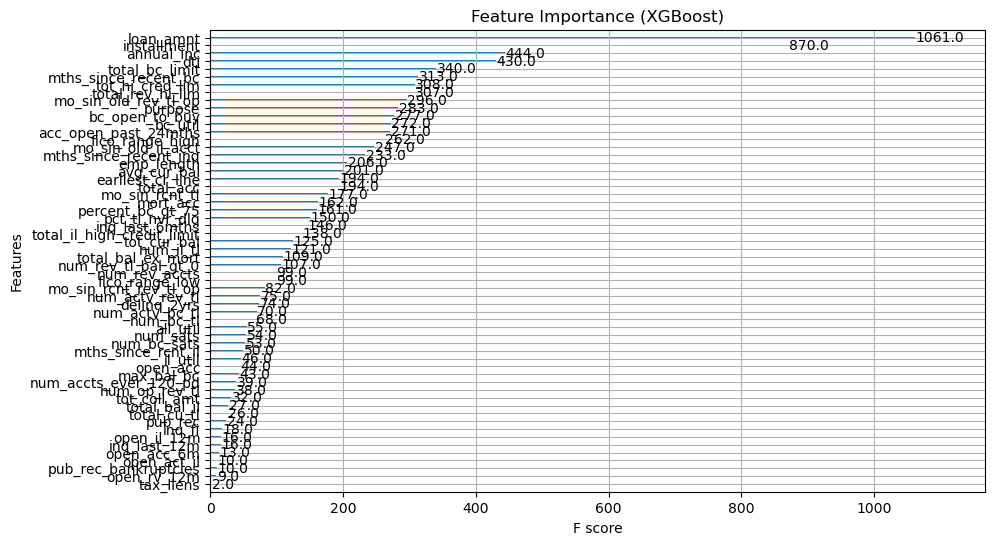

In [8]:
# Feature Importance
import matplotlib.pyplot as plt

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [9]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

importance_df

,Feature,Importance
16,loan_amnt,1061.0
15,installment,870.0
2,annual_inc,444.0
6,dti,430.0
48,total_bc_limit,340.0
24,mths_since_recent_bc,313.0
49,tot_hi_cred_lim,308.0
52,total_rev_hi_lim,307.0
19,mo_sin_old_rev_tl_op,296.0
51,purpose,283.0
